In [2]:
import argparse
import importlib.util

import tensorflow as tf
import h5py
import pickle
import matplotlib.pyplot as plt

from alad_mod.alad import ALAD
from data.hlf_dataset_utils import *
from data.hlf_preprocessing import load
from evaluation.histogram_builder import *
from evaluation.plot_utils import *

In [3]:
result_path = '/home/oliverkn/pro/alad_6021/2_l16_1'
model_file = 'model-10000000'

print('loading alad')

# loading config
spec = importlib.util.spec_from_file_location('config', os.path.join(result_path, 'config.py'))
config_alad = importlib.util.module_from_spec(spec)
spec.loader.exec_module(config_alad)

# loading preprocessor
preprocessor = load(os.path.join(result_path, 'preprocessor.pkl'))

# loading alad
tf.reset_default_graph()
ad = ALAD(config_alad, tf.Session())
ad.load(os.path.join(result_path, model_file))

loading alad


W1021 09:14:36.820805 140052467447616 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W1021 09:14:36.863090 140052467447616 deprecation_wrapper.py:119] From /home/oliverkn/cloud/eth/2019_FS/pro/pycharm/alad_mod/alad.py:29: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1021 09:14:36.866117 140052467447616 deprecation_wrapper.py:119] From /home/oliverkn/cloud/eth/2019_FS/pro/pycharm/alad_mod/alad.py:44: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W1021 09:14:36.866973 140052467447616 deprecation.py:323] From /home/oliverkn/pro/alad_6021/2_l16_1/config.py:81: dense (from te

In [4]:
score_type = 'fm'

def build_hists(x, n_max, eff, preselect, batch_size=2 ** 20, build_ano=True):
    hist_builder_all = HistogramBuilder(settings_6021)
    hist_builder_anomalous = HistogramBuilder(settings_6021)

    n = x.shape[0]
    n = min(n, n_max)

    n_batches = int(n / batch_size) + 1
    for t in range(n_batches):
        print('batch number ' + str(t))

        ran_from = int(t * batch_size)
        ran_to = (t + 1) * batch_size
        ran_to = int(np.clip(ran_to, 0, n))
        x_batch = x[ran_from:ran_to]
        
        # preselection
        if preselect:
            #filter_iso = x_batch[:,7]+x_batch[:,8]+x_batch[:,9] < 0.15
            filter_eta = np.abs(x_batch[:,5]) < 1.4
            filter_njets = x_batch[:,2] > 1

            filter_idx = filter_njets * filter_eta #filter_iso * filter_eta * filter_njets
            x_batch = x_batch[filter_idx]
        
        hist_builder_all.add_data(x_batch)
        
        if build_ano:
            x_batch_transformed = preprocessor.transform(x_batch)
            scores = ad.get_anomaly_scores(x_batch_transformed, type=score_type)
            thres = np.quantile(scores, 1.-eff)
            
            anomaly_idx = scores >= thres
            hist_builder_anomalous.add_data(x_batch[anomaly_idx])
        
    return hist_builder_all.get_histogram_data(), hist_builder_anomalous.get_histogram_data()

def build_hists_thres(x, n_max, thres, preselect, batch_size=2 ** 20, build_ano=True):
    hist_builder_all = HistogramBuilder(settings_6021)
    hist_builder_anomalous = HistogramBuilder(settings_6021)

    n = x.shape[0]
    n = min(n, n_max)

    n_batches = int(n / batch_size) + 1
    for t in range(n_batches):
        print('batch number ' + str(t))

        ran_from = int(t * batch_size)
        ran_to = (t + 1) * batch_size
        ran_to = int(np.clip(ran_to, 0, n))
        x_batch = x[ran_from:ran_to]
        
        # preselection
        if preselect:
            #filter_iso = x_batch[:,7]+x_batch[:,8]+x_batch[:,9] < 0.15
            filter_eta = np.abs(x_batch[:,5]) < 1.4
            filter_njets = x_batch[:,2] > 1

            filter_idx = filter_njets * filter_eta #filter_iso * filter_eta * filter_njets
            x_batch = x_batch[filter_idx]
        
        hist_builder_all.add_data(x_batch)
        
        if build_ano:
            x_batch_transformed = preprocessor.transform(x_batch)
            scores = ad.get_anomaly_scores(x_batch_transformed, type=score_type)
            
            anomaly_idx = scores >= thres
            hist_builder_anomalous.add_data(x_batch[anomaly_idx])
        
    return hist_builder_all.get_histogram_data(), hist_builder_anomalous.get_histogram_data()
    

In [5]:
# build mc
n_max = int(1e6)
preselect = True
thres = 100

file_dy1jets = '/home/oliverkn/pro/7719/data.hdf5'
file_dy2jets = '/home/oliverkn/pro/7721/data.hdf5'
file_dy3jets = '/home/oliverkn/pro/7722/data.hdf5'
file_dy4jets = '/home/oliverkn/pro/7723/data.hdf5'

file_w1jets = '/home/oliverkn/pro/9863/data.hdf5'
file_w2jets = '/home/oliverkn/pro/9864/data.hdf5'
file_w3jets = '/home/oliverkn/pro/9865/data.hdf5'

file_ttbar = '/home/oliverkn/pro/9588/data.hdf5'

sets = {}
sets['dy1jets'] = {'file': '/home/oliverkn/pro/7719/data.hdf5', 'xsec':561, 'K':1.23, 'N_tot':65949083}
sets['dy2jets'] = {'file': '/home/oliverkn/pro/7721/data.hdf5', 'xsec':181, 'K':1.23, 'N_tot':21732511}
sets['dy3jets'] = {'file': '/home/oliverkn/pro/7722/data.hdf5', 'xsec':51, 'K':1.23, 'N_tot':11025803}
sets['dy4jets'] = {'file': '/home/oliverkn/pro/7723/data.hdf5', 'xsec':15, 'K':1.23, 'N_tot':6361350}

sets['w1jets'] = {'file': '/home/oliverkn/pro/9863/data.hdf5', 'xsec':4480, 'K':1.23, 'N_tot':29784800}
sets['w2jets'] = {'file': '/home/oliverkn/pro/9864/data.hdf5', 'xsec':1435, 'K':1.23, 'N_tot':30693853}
sets['w3jets'] = {'file': '/home/oliverkn/pro/9865/data.hdf5', 'xsec':304, 'K':1.23, 'N_tot':15241144}

sets['ttbar'] = {'file': '/home/oliverkn/pro/9588/data.hdf5', 'xsec':164, 'K':1.66, 'N_tot':0}

mc_file_list = [file_dy1jets,file_dy2jets,file_dy3jets,file_dy4jets,file_w1jets,file_w2jets,file_w3jets,file_ttbar]

# compute hist for every file

for key, set in sets.items():
    file = set['file']
    print('building ' + key)
    
    x = h5py.File(file, 'r')['data']
    hist, hist_a = build_hists_thres(x, n_max=n_max, thres=thres, preselect = preselect)
    
    n_events = hist['HT']['n']
    n_events_a =hist_a['HT']['n']
    
    set['n_tot'] = x.shape[0]
    set['hist'] = hist
    set['hist_a'] = hist_a
    
    print('%d / %d = %3d_ppm' % (n_events_a, n_events, (n_events_a / n_events*1e6)))

building dy1jets
batch number 0
796 / 533658 = 1491_ppm
building dy2jets
batch number 0
751 / 568613 = 1320_ppm
building dy3jets
batch number 0
1537 / 583612 = 2633_ppm
building dy4jets
batch number 0
4840 / 584952 = 8274_ppm
building w1jets
batch number 0
471 / 447367 = 1052_ppm
building w2jets
batch number 0
701 / 541204 = 1295_ppm
building w3jets
batch number 0
1111 / 584963 = 1899_ppm
building ttbar
batch number 0
9319 / 774802 = 12027_ppm


[0.0773971  0.02497126 0.0070361  0.00206944 0.61807312 0.19797655
 0.04194068 0.03053576]
[0.02755404 0.02759739 0.01522905 0.00756557 0.58044799 0.20948265
 0.09504898 0.03707432]
[0.02433156 0.02157873 0.02374419 0.03705967 0.36178866 0.16063485
 0.10687295 0.2639894 ]


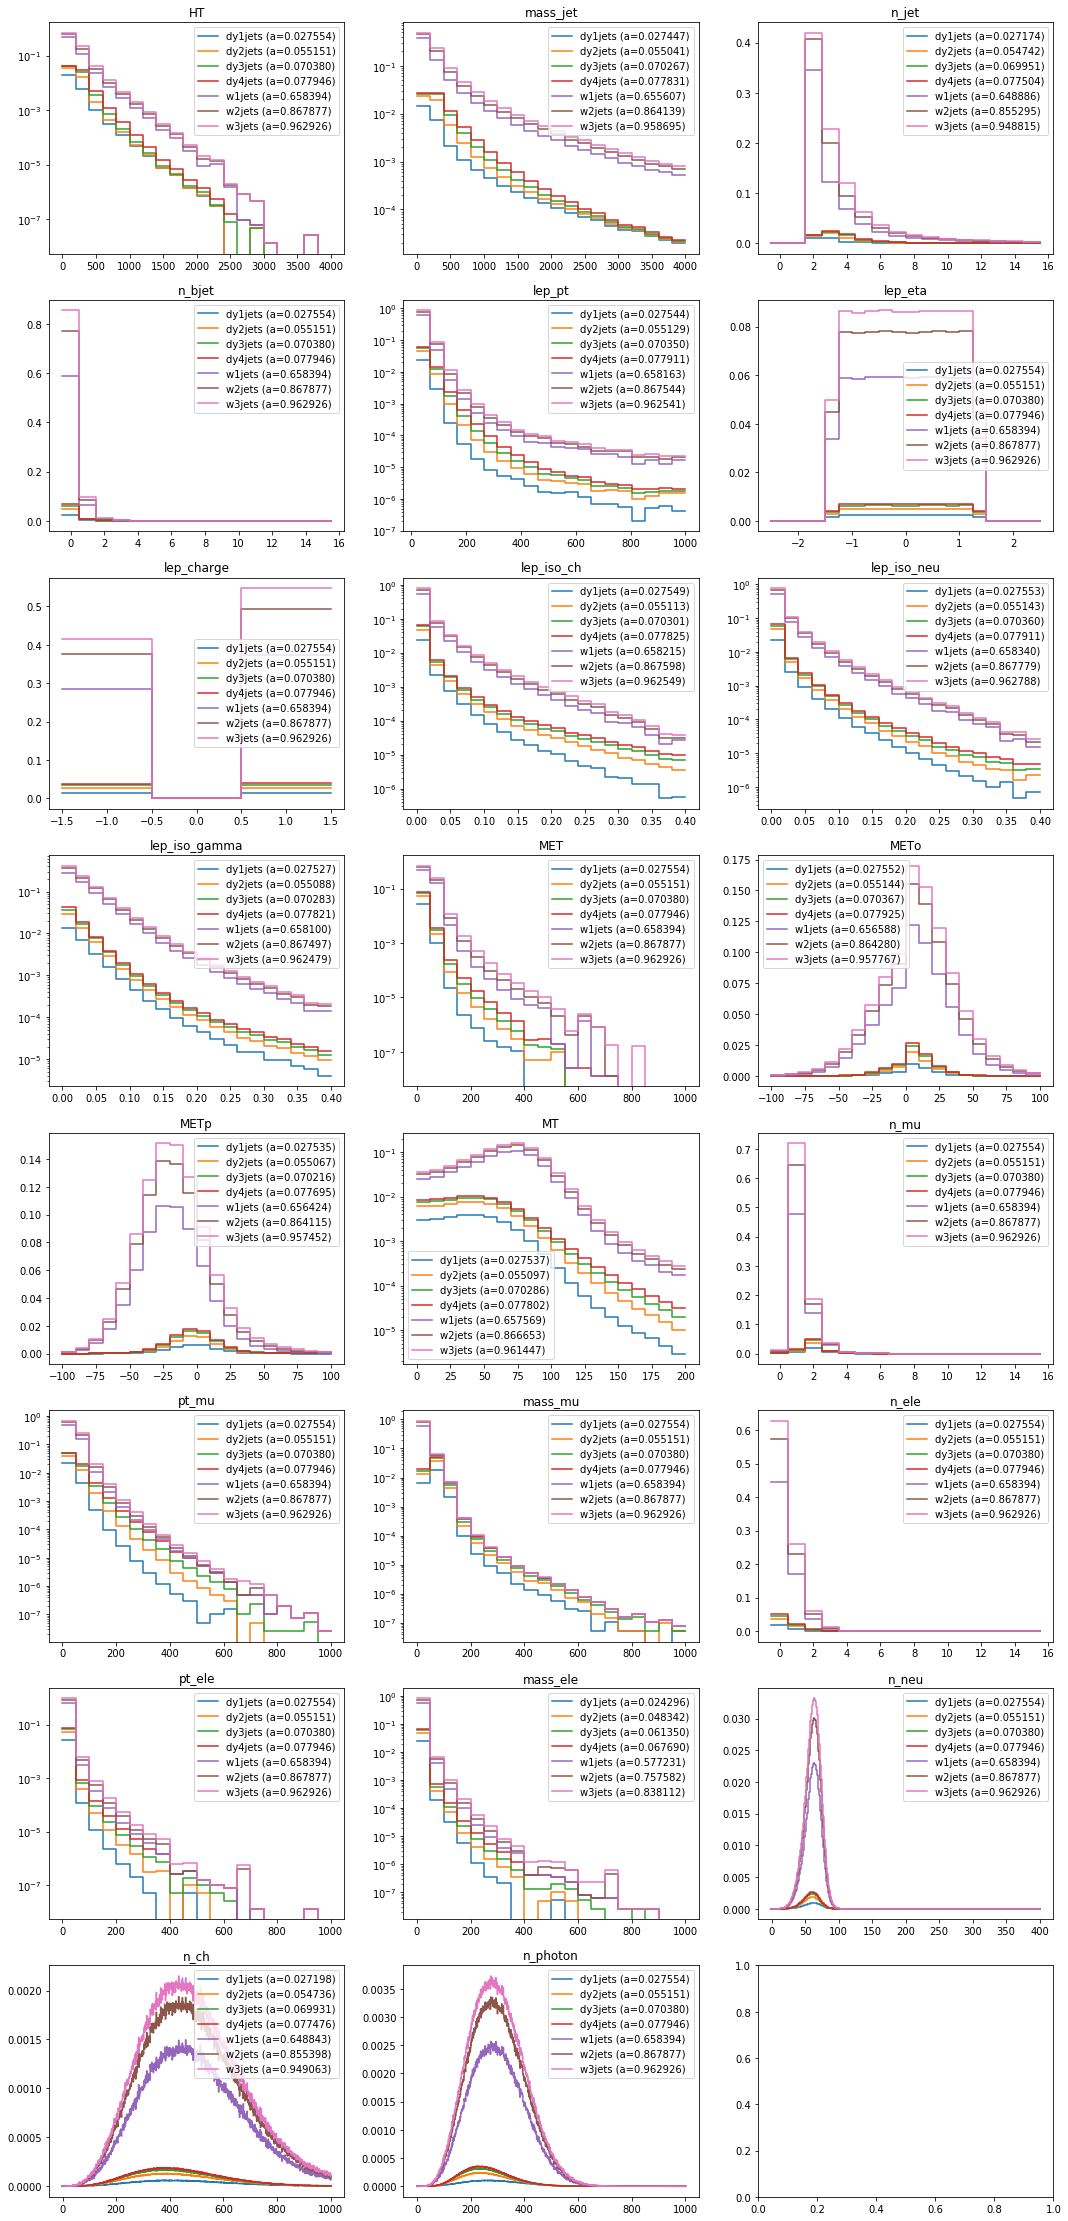

In [10]:
# compute weights for pdfs
weights_init = []
weights_pres = []
weights_a = []

weights_a = []
for key, set in sets.items():
    n_a = set['hist_a']['HT']['n']
    n_pres = set['hist']['HT']['n']
    n_tot = set['n_tot']
    k = set['K']
    xsec = set['xsec']
    
    w_init = xsec * k
    w_pres = w_init * n_pres/n_tot
    w_a = w_init * n_a/n_tot
    
    weights_init.append(w_init)
    weights_pres.append(w_pres)
    weights_a.append(w_a)

weights_init = np.array(weights_init)
weights_pres = np.array(weights_pres)
weights_a = np.array(weights_a)

# normalizing weights
weights_init = weights_init/np.sum(weights_init)
weights_pres = weights_pres/np.sum(weights_pres)
weights_a = weights_a/np.sum(weights_a)

print(weights_init)
print(weights_pres)
print(weights_a)

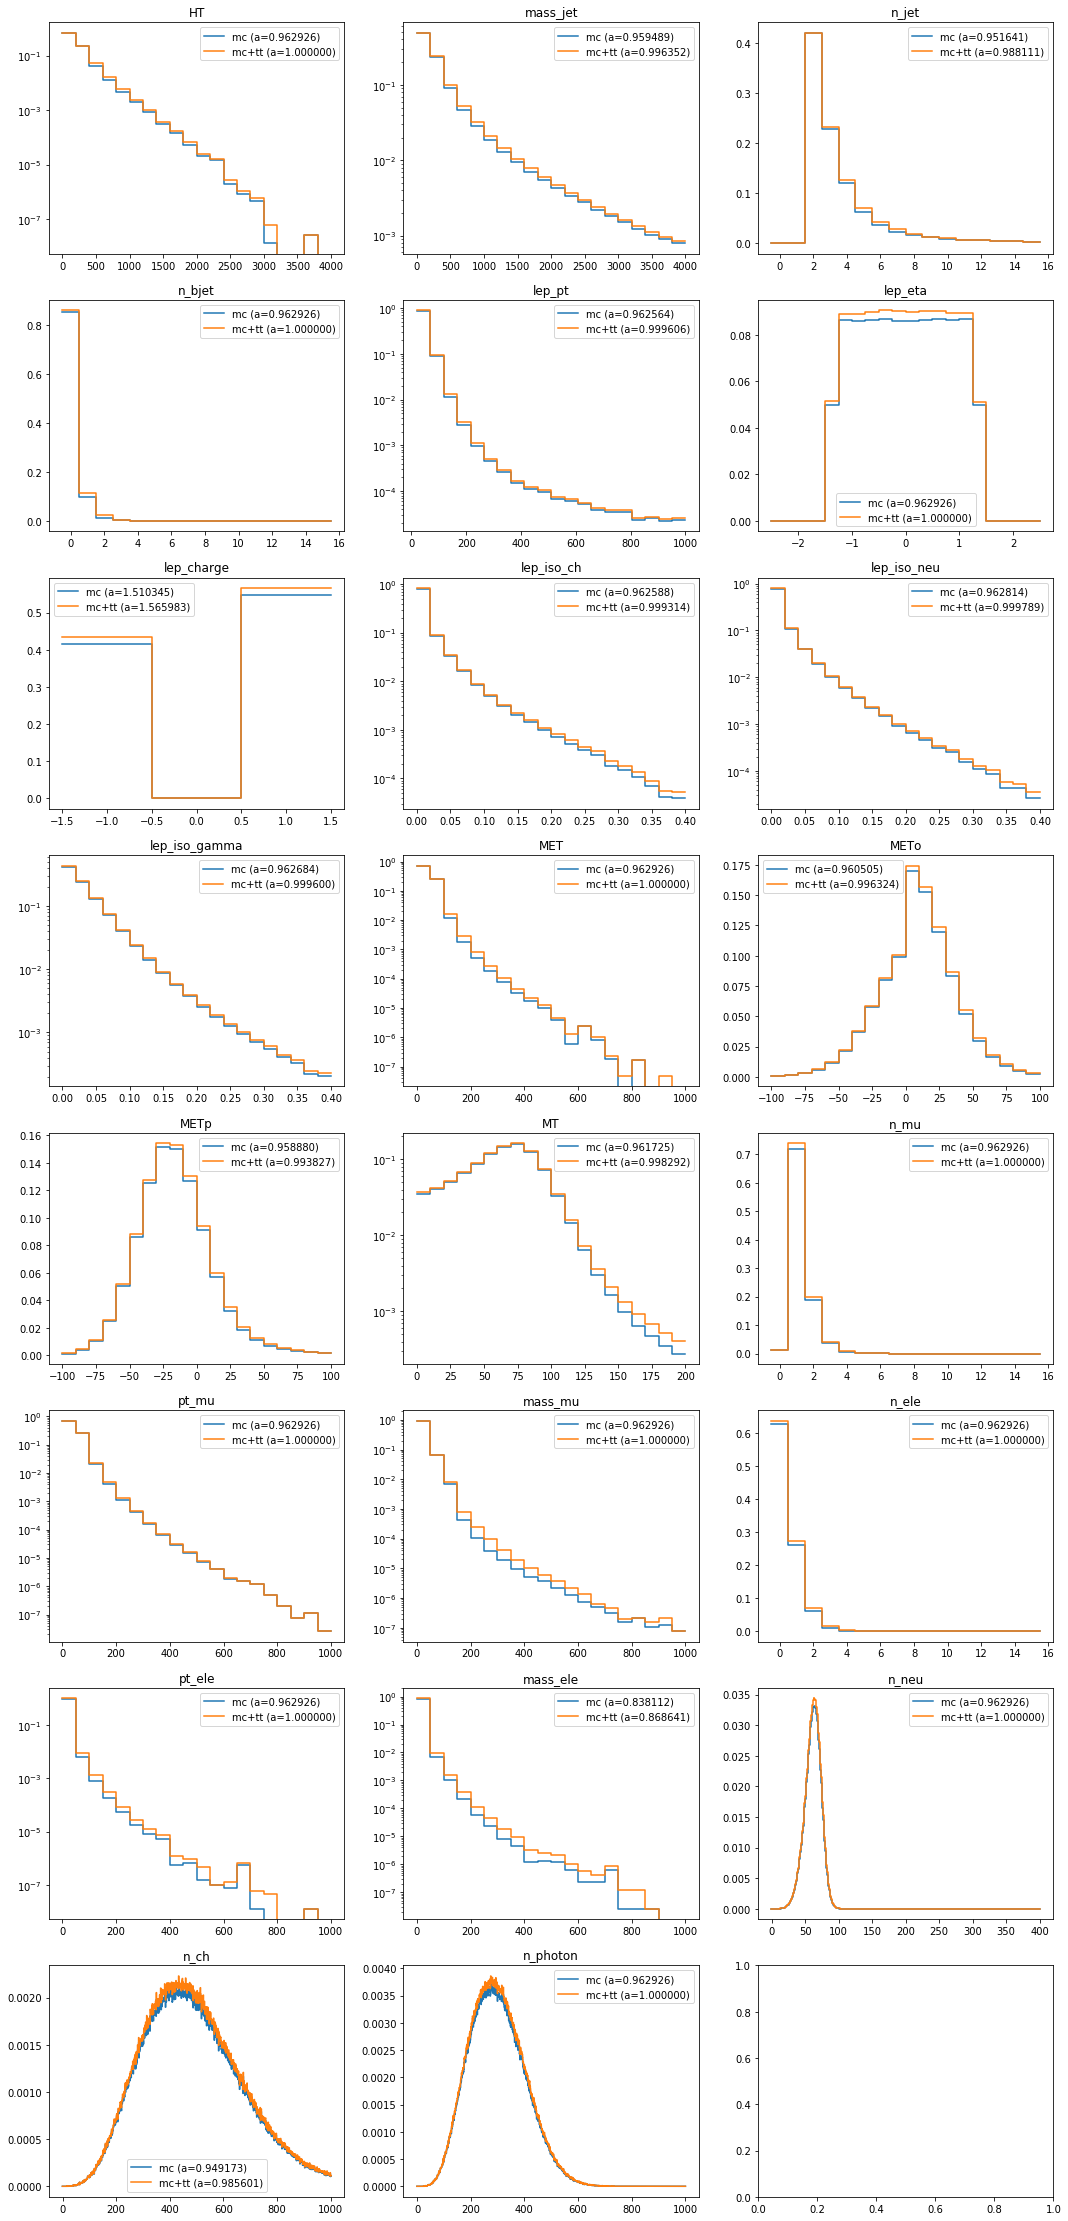

In [13]:
# add mc pdfs
mc_key_list = ['dy1jets','dy2jets','dy3jets','dy4jets', 'w1jets','w2jets','w3jets']
mc_hist_list = [sets[key]['hist'] for key in mc_key_list]
mc_hist = sum_hists(mc_hist_list, weights_pres[:-1])

mc_ttbar_key_list = ['dy1jets','dy2jets','dy3jets','dy4jets', 'w1jets','w2jets','w3jets', 'ttbar']
mc_ttbar_hist_list = [sets[key]['hist'] for key in mc_ttbar_key_list]
mc_ttbar_hist = sum_hists(mc_ttbar_hist_list, weights_pres)

#plot_stacked_hist(mc_hist_list, mc_key_list, weights_pres, settings_6021)

# mc + ttbar
plot_hist([mc_hist, mc_ttbar_hist], ['mc', 'mc+tt'], settings_6021)





# bins = set['hist']['HT']['bin_edges']
# content = set['hist']['HT']['pdf']
# 
# plt.hist([bins[:-1]]*2, bins, weights=[content]*2, histtype='stepfilled', stacked=True)
# plt.yscale('lin')

In [ ]:
# 

file_data = '/home/oliverkn/pro/6021/data.hdf5'
x_ttbar = h5py.File(file_ttbar, "r")['data']

x_data = h5py.File(file_data, "r")['data']



#mc


#ttbar
hist_ttbar, hist_ttbar_ano = build_hists_thres(x_ttbar, n_max=n_max, thres=thres, preselect = preselect)
print('anomalous events: %d' % hist_ttbar_ano['HT']['n'])
print('anomalous fraction: %3d_ppm' % (hist_ttbar_ano['HT']['n'] / hist_ttbar['HT']['n']*1e6))

In [26]:
# data
hist_data, hist_data_ano = build_hists_thres(x_data, n_max=n_max, thres=thres, preselect = preselect)
print('anomalous events: %d' % hist_data_ano['HT']['n'])
print('anomalous fraction: %3d_ppm' % (hist_data_ano['HT']['n'] / hist_data['HT']['n']*1e6))

batch number 0
batch number 1
batch number 2
batch number 3
batch number 4
batch number 5
batch number 6
batch number 7
batch number 8
batch number 9
batch number 10
batch number 11
batch number 12
batch number 13
batch number 14
batch number 15
batch number 16
batch number 17
batch number 18
batch number 19
anomalous events: 721
anomalous fraction: 107_ppm


[0.98097246 0.01902754]
[0.80916554 0.19083446]
saving fig to hist_anomalous.pdf


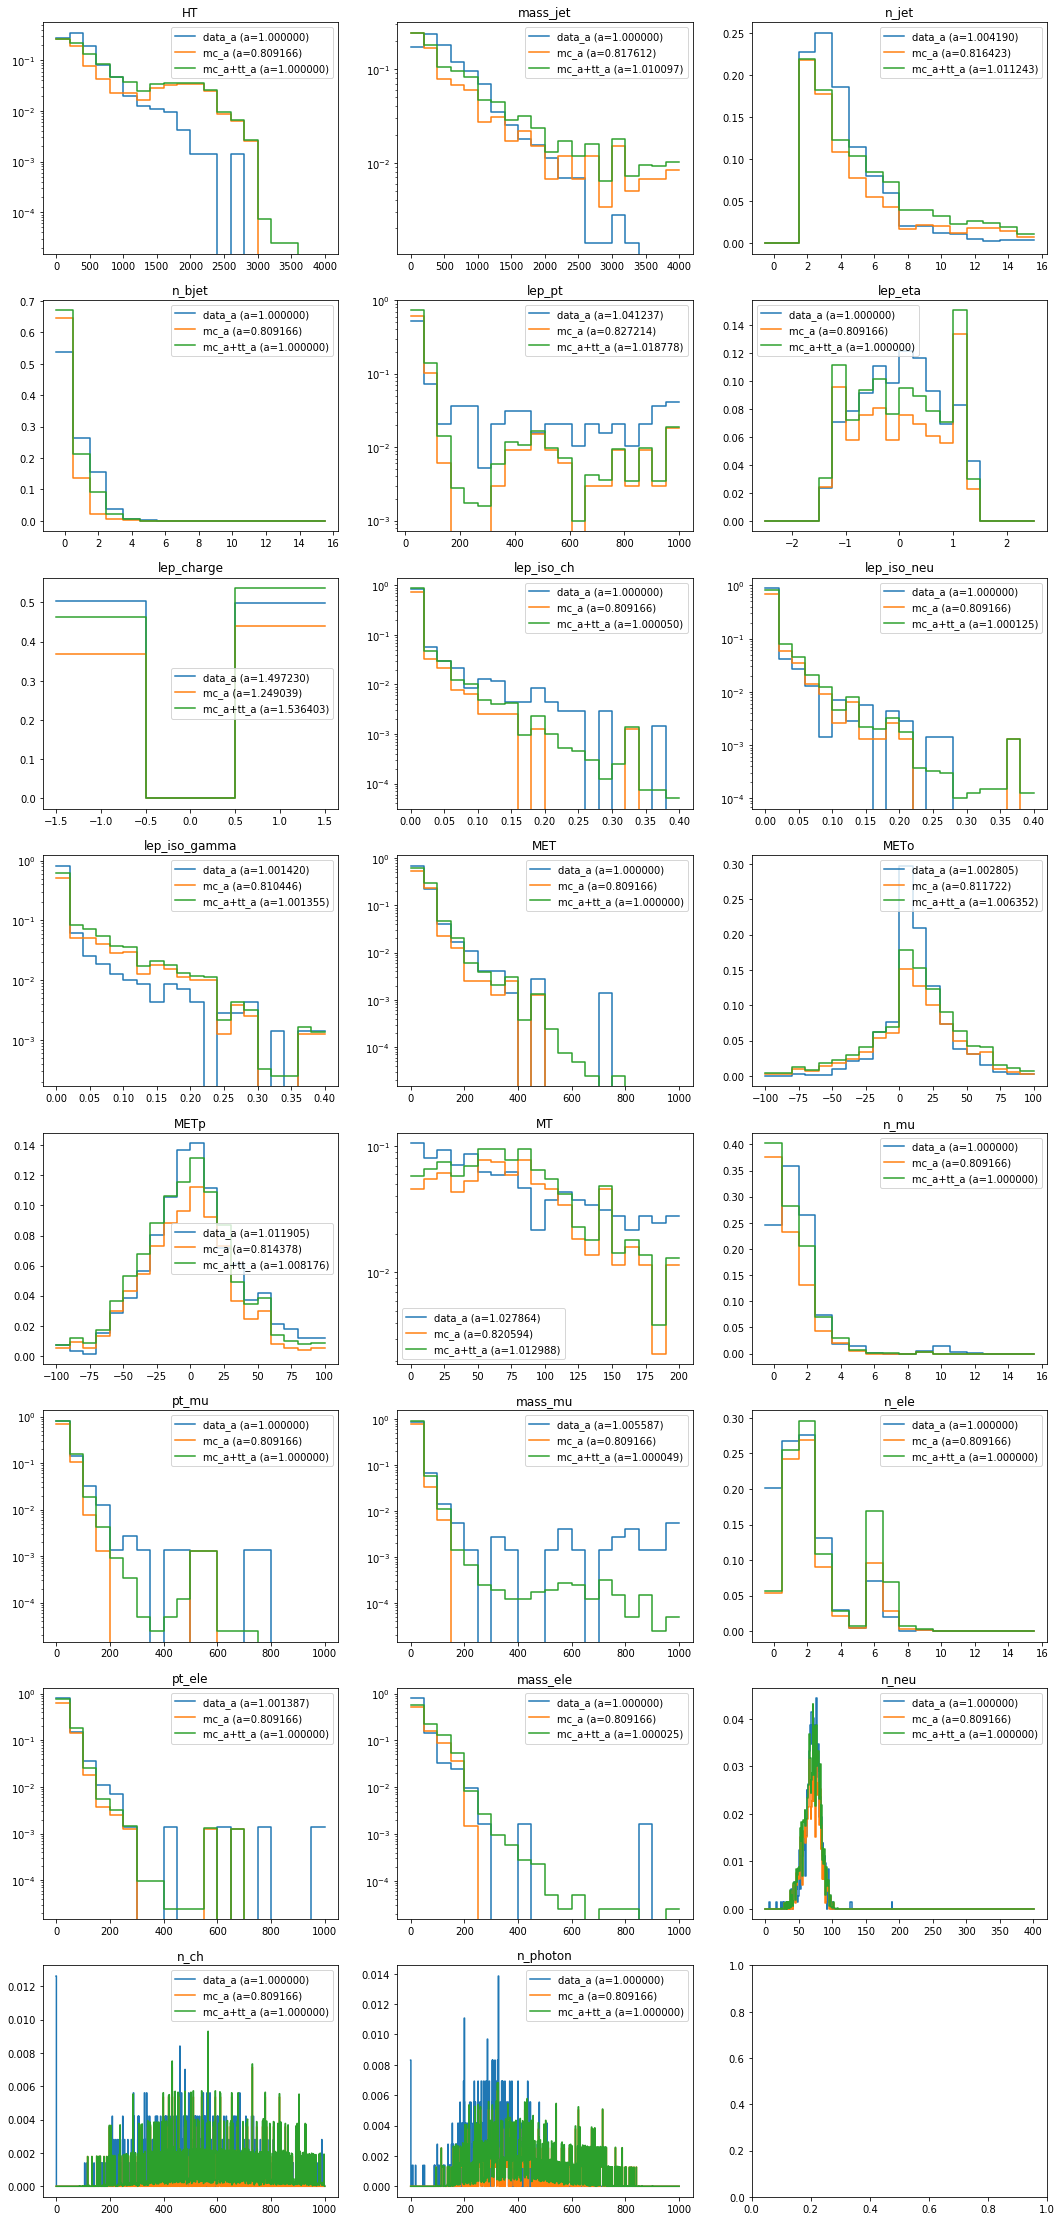

In [27]:
#plot anomalous

n_mc_a = hist_mc_ano['HT']['n'] #TODO
n_ttbar_a = hist_ttbar_ano['HT']['n'] #TODO

w_xsec =  np.array([7027, 136.3])
w_xsec = w_xsec / np.sum(w_xsec)
w_ad = np.array([n_mc_a, n_ttbar_a])
w_ad = w_ad / np.sum(w_ad)

w = w_xsec * w_ad
w = w/np.sum(w)

print(w_xsec)
print(w)

hist_mc_ttbar_ano = {}
for name in hist_mc_ano.keys():
    hist_mc_ttbar_ano[name] = {}
    hist_mc_ttbar_ano[name]['bin_edges'] = hist_mc_ano[name]['bin_edges']
    hist_mc_ttbar_ano[name]['pdf'] = w[0] * hist_mc_ano[name]['pdf'] + w[1] * hist_ttbar_ano[name]['pdf']
    
hist_mc_ano_res = {}
for name in hist_mc_ano.keys():
    hist_mc_ano_res[name] = {}
    hist_mc_ano_res[name]['bin_edges'] = hist_mc_ano[name]['bin_edges']
    hist_mc_ano_res[name]['pdf'] = w[0] * hist_mc_ano[name]['pdf'] 

#plot_stacked_hist([hist_mc_ano, hist_ttbar_ano], ['mc_a','mc_a+tt_a'],w, settings_6021)
plot_hist([hist_data_ano, hist_mc_ano_res, hist_mc_ttbar_ano], ['data_a','mc_a','mc_a+tt_a'], settings_6021, output_file='hist_anomalous.pdf')

saving fig to hist_normal.pdf


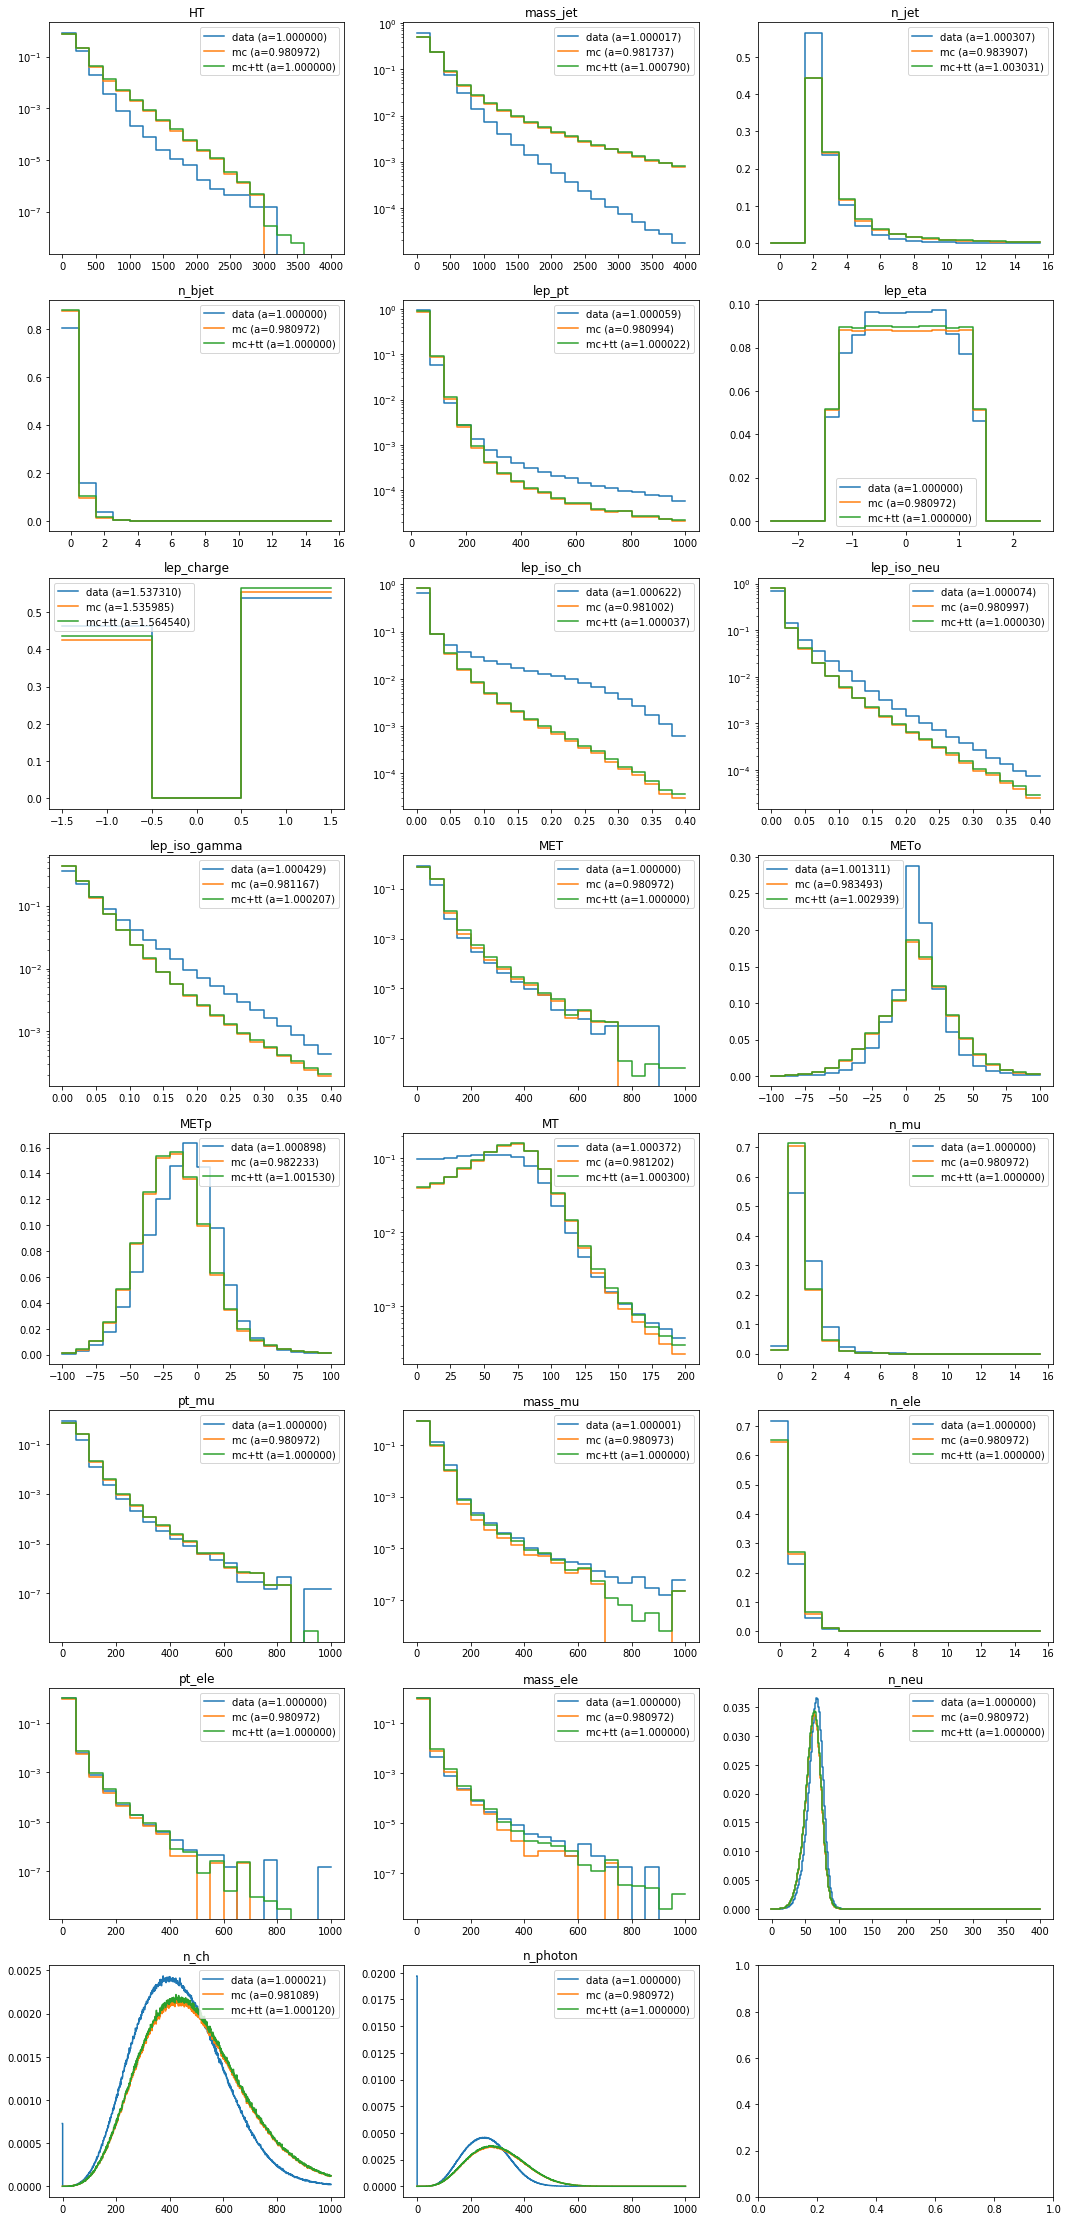

In [11]:
hist_mc_res = {}
for name in hist_mc.keys():
    hist_mc_res[name] = {}
    hist_mc_res[name]['bin_edges'] = hist_mc[name]['bin_edges']
    hist_mc_res[name]['pdf'] = w_xsec[0] * hist_mc[name]['pdf'] 

hist_mc_ttbar = add(hist_mc, hist_ttbar, w_xsec[0], w_xsec[1])

plot_hist([hist_data, hist_mc_res, hist_mc_ttbar], ['data', 'mc','mc+tt'], settings_6021, output_file='hist_normal.pdf')

In [ ]:
plot_stacked_hist([hist_mc, hist_ttbar], ['mc','mc+tt'],w_xsec, settings_6021)

In [ ]:
plot_hist([hist_data_ano, hist_mc_ano, hist_ttbar_ano], ['data_a','mc_a', 'mc_ttbar_a'], settings_6021, output_file='data_vs_mc.pdf')
#plot_hist([hist_data_ano, hist_mc_ano, hist_ttbar], ['data','mc','ttbar'], settings_6021, output_file='data_vs_mc.pdf')
#plot_hist([hist_data,hist_mc,hist_data_ano, hist_mc_ano, hist_ttbar], ['data all','mc all','data','mc','ttbar'], settings_6021)

In [ ]:
w=0.6

hist_delta = {}
for name in hist_data_ano.keys():
    hist_delta[name] = {}
    hist_delta[name]['bin_edges'] = hist_data_ano[name]['bin_edges']
    noise = hist_mc_ano[name]['pdf']
    #noise = noise * hist_data[name]['pdf']/hist_mc[name]['pdf']
    hist_delta[name]['pdf'] = (hist_data_ano[name]['pdf'] - w*noise)/(1-w)
    
plot_hist([hist_data_ano, hist_delta, hist_ttbar], ['data','data adj.','ttbar'], settings_6021,output_file='data_adj.pdf')

In [ ]:
plot_hist([hist_data, hist_mc, hist_ttbar], ['data','mc','ttbar'], settings_6021)

In [ ]:
hist_file_all = os.path.join(target, 'all.pkl')
hist_file_normal = os.path.join(target,'%3d_ppm' % (n_anomalous / n_tot*1e6)+'_n.pkl')
hist_file_anomalous = os.path.join(target,'%3d_ppm' % (n_anomalous / n_tot*1e6)+'_a.pkl')

print('saving data to ' + hist_file_all)
pickle.dump(hist_data_all, open(hist_file_all, 'wb'))

print('saving normal data to ' + hist_file_normal)
pickle.dump(hist_data_normal, open(hist_file_normal, 'wb'))

print('saving anomalous data to ' + hist_file_anomalous)
pickle.dump(hist_data_anomalous, open(hist_file_anomalous, 'wb'))